In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import plotly.graph_objects as go

# K-mean Venue-data within 1km

In [4]:
# Import venue data within 1km of each neighborhood
venue_data = pd.read_csv('/Users/karina/GitHub/NYC_midterm_project/data/data/all_venues_data_1km.csv')
venue_data.head()

,id,accounting,amusement_park,aquarium,art_gallery,bakery,bank,bar,beauty_salon,bicycle_store,...,supermarket,synagogue,taxi_stand,tourist_attraction,train_station,transit_station,travel_agency,university,veterinary_care,zoo
0,nyu_2451_34572.1,1,0,0,0,1,2,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,nyu_2451_34572.10,0,0,0,0,1,1,0,2,0,...,1,0,0,0,0,0,0,0,0,0
2,nyu_2451_34572.100,0,0,0,0,1,0,4,1,0,...,0,0,0,0,0,0,0,0,0,0
3,nyu_2451_34572.101,0,0,0,1,2,0,4,0,0,...,0,0,0,2,0,0,0,0,0,0
4,nyu_2451_34572.102,0,0,0,0,0,2,5,0,0,...,0,1,0,0,0,0,1,0,0,0


In [5]:
# Create function to find the most common venues per neighborhood
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [6]:
# Create new dataframe for most common venues
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['id']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['id'] = venue_data['id']

for ind in np.arange(venue_data.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(venue_data.iloc[ind, :], num_top_venues)

In [7]:
venues_sorted.head()

,id,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,nyu_2451_34572.1,school,doctor,health,secondary_school,church
1,nyu_2451_34572.10,church,secondary_school,school,funeral_home,general_contractor
2,nyu_2451_34572.100,doctor,bar,health,restaurant,dentist
3,nyu_2451_34572.101,lodging,cafe,night_club,bar,restaurant
4,nyu_2451_34572.102,doctor,restaurant,bar,church,park


In [8]:
# Import neighborhood data
neighborhood_data = pd.read_csv('/Users/karina/GitHub/NYC_midterm_project/data/old_dataset.csv')
neighborhood_data = neighborhood_data.iloc[:, 1:6]
neighborhood_data.head()

,id,borough,neighborhood,longitude,latitude
0,nyu_2451_34572.1,Bronx,Wakefield,-73.847201,40.894705
1,nyu_2451_34572.2,Bronx,Co-op City,-73.829939,40.874294
2,nyu_2451_34572.3,Bronx,Eastchester,-73.827806,40.887556
3,nyu_2451_34572.4,Bronx,Fieldston,-73.905643,40.895437
4,nyu_2451_34572.5,Bronx,Riverdale,-73.912585,40.890834


In [9]:
# Drop neighborhood ID to create numerical data for k-means clustering
venue_clustering = venue_data.drop('id', axis=1)

In [10]:
# Create elbow graph function
def plot_distortion(X,max_clusters = 10):
    distortions = []
    for i in range(1, max_clusters +1):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    random_state=0)
        km.fit(X)
        distortions.append(km.inertia_)

    plt.plot(range(1,max_clusters +1), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show() 

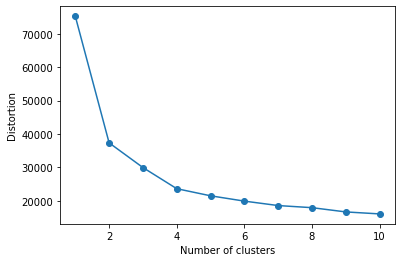

In [11]:
# Plot elbow graph
plot_distortion(venue_clustering)

In [12]:
# Cluster data points using kmeans and get labels
kclusters = 3

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venue_clustering)

kmeans.labels_[0:10] 

array([0, 0, 2, 0, 0, 2, 0, 0, 0, 2], dtype=int32)

In [13]:
# Add cluster labels to venue data
venues_sorted.insert(0, 'clusters', kmeans.labels_)
clusters = venues_sorted.clusters.tolist()
venues_sorted = venues_sorted.drop('clusters', axis=1)

# Merge venue data with neighborhood data
all_venue_data = neighborhood_data.copy()
all_venue_data = pd.merge(all_venue_data, venues_sorted, on='id')
all_venue_data['clusters'] = clusters
all_venue_data = all_venue_data.drop('id', axis=1)

all_venue_data.head()

,borough,neighborhood,longitude,latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,clusters
0,Bronx,Wakefield,-73.847201,40.894705,school,doctor,health,secondary_school,church,0
1,Bronx,Co-op City,-73.829939,40.874294,health,store,dentist,doctor,physiotherapist,0
2,Bronx,Eastchester,-73.827806,40.887556,store,car_repair,general_contractor,lodging,physiotherapist,2
3,Bronx,Fieldston,-73.905643,40.895437,doctor,school,health,restaurant,home_goods_store,0
4,Bronx,Riverdale,-73.912585,40.890834,doctor,school,dentist,synagogue,health,0


### Mapping

In [14]:
import folium
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors

In [15]:
# Create a map of new york

address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [16]:
# Plot clusters on map of New York
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(all_venue_data['latitude'], all_venue_data['longitude'], all_venue_data['neighborhood'],all_venue_data['clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [17]:
cluster0 = all_venue_data.loc[all_venue_data['clusters'] == 0, all_venue_data.columns[[1] + list(range(4, all_venue_data.shape[1]))]]
cluster1 = all_venue_data.loc[all_venue_data['clusters'] == 1, all_venue_data.columns[[1] + list(range(4, all_venue_data.shape[1]))]]
cluster2 = all_venue_data.loc[all_venue_data['clusters'] == 2, all_venue_data.columns[[1] + list(range(4, all_venue_data.shape[1]))]]

In [18]:
print('--cluster0--')
print()
print('Top 5 most common venue type')
print(cluster0['1st Most Common Venue'].value_counts()[:5])
print()
print('Top 5 second most common venue type')
print(cluster0['2nd Most Common Venue'].value_counts()[:5])
print()
print('Top 5 third most common venue type')
print(cluster0['3rd Most Common Venue'].value_counts()[:5])

--cluster0--

Top 5 most common venue type
doctor                99
lodging               20
general_contractor    18
restaurant            15
school                14
Name: 1st Most Common Venue, dtype: int64

Top 5 second most common venue type
health        33
restaurant    32
school        23
doctor        19
dentist       12
Name: 2nd Most Common Venue, dtype: int64

Top 5 third most common venue type
health              26
restaurant          21
school              17
secondary_school    13
dentist             13
Name: 3rd Most Common Venue, dtype: int64


In [19]:
print('--cluster1--')
print()
print('Top 5 most common venue type')
print(cluster1['1st Most Common Venue'].value_counts()[:5])
print()
print('Top 5 second most common venue type')
print(cluster1['2nd Most Common Venue'].value_counts()[:5])
print()
print('Top 5 third most common venue type')
print(cluster1['3rd Most Common Venue'].value_counts()[:5])

--cluster1--

Top 5 most common venue type
doctor                12
school                 4
general_contractor     3
lodging                2
car_repair             1
Name: 1st Most Common Venue, dtype: int64

Top 5 second most common venue type
health                5
dentist               3
doctor                3
restaurant            3
general_contractor    2
Name: 2nd Most Common Venue, dtype: int64

Top 5 third most common venue type
health                4
general_contractor    3
school                2
secondary_school      2
lawyer                2
Name: 3rd Most Common Venue, dtype: int64


In [20]:
print('--cluster2--')
print()
print('Top 5 most common venue type')
print(cluster2['1st Most Common Venue'].value_counts()[:5])
print()
print('Top 5 second most common venue type')
print(cluster2['2nd Most Common Venue'].value_counts()[:5])
print()
print('Top 5 third most common venue type')
print(cluster2['3rd Most Common Venue'].value_counts()[:5])

--cluster2--

Top 5 most common venue type
doctor     19
lodging     8
health      5
church      3
bar         3
Name: 1st Most Common Venue, dtype: int64

Top 5 second most common venue type
restaurant            12
doctor                 5
health                 4
secondary_school       3
general_contractor     3
Name: 2nd Most Common Venue, dtype: int64

Top 5 third most common venue type
restaurant            7
health                6
school                5
general_contractor    3
bank                  3
Name: 3rd Most Common Venue, dtype: int64


In [21]:
def plot_clusters(X,y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []

    for cluster in set(y_res):
        x = X[y_res == cluster,0]
        y = X[y_res == cluster,1]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        plt.scatter(x,
                    y,
                    s=50,
                    marker='s',
                    label=f'cluster {cluster}')

    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='red',
                    s=250,
                    label='centroids')
    plt.legend()
    plt.grid()
    plt.show()

In [22]:
y_km = kmeans.fit_predict(venue_clustering)

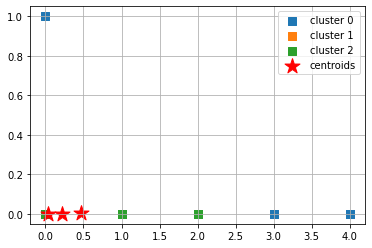

In [23]:
plot_clusters(np.array(venue_clustering), y_km, plt_cluster_centers= True)

# Resturant Data

In [24]:
# Import venue data within 1km of each neighborhood
restaurant_data = pd.read_csv('/Users/karina/GitHub/NYC_midterm_project/data/data/yelp_restaurant_type_counts_1km.csv')
restaurant_data.columns.values[0] = "id"
restaurant_data.head()

,id,caribbean,cocktailbars,seafood,spanish,chinese,breakfast_brunch,japanese,thai,wraps,...,pharmacy,farmersmarket,foodtours,bowling,syrian,southafrican,eventservices,bookstores,homedecor,diyfood
0,nyu_2451_34572.1,17.0,1.0,3.0,1.0,4.0,3.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,nyu_2451_34572.2,5.0,0.0,4.0,0.0,4.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,nyu_2451_34572.3,7.0,0.0,5.0,0.0,1.0,4.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,nyu_2451_34572.4,0.0,0.0,0.0,0.0,2.0,1.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,nyu_2451_34572.5,0.0,2.0,2.0,0.0,3.0,1.0,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# Create new dataframe for most common venues
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['id']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
restaurant_sorted = pd.DataFrame(columns=columns)
restaurant_sorted['id'] = restaurant_data['id']

for ind in np.arange(restaurant_data.shape[0]):
    restaurant_sorted.iloc[ind, 1:] = return_most_common_venues(restaurant_data.iloc[ind, :], num_top_venues)

restaurant_sorted.head()

,id,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,nyu_2451_34572.1,caribbean,pizza,sandwiches,burgers,chinese
1,nyu_2451_34572.2,hotdogs,pizza,caribbean,seafood,chicken_wings
2,nyu_2451_34572.3,caribbean,hotdogs,burgers,seafood,pizza
3,nyu_2451_34572.4,bars,delis,tradamerican,mexican,pizza
4,nyu_2451_34572.5,sandwiches,delis,pizza,burgers,bars


In [26]:
# Numeric Data for clustering
restaurant_clustering = restaurant_data.drop('id', axis=1)

### K-Means

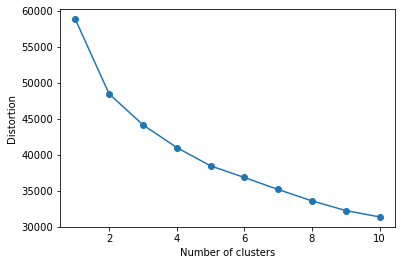

In [27]:
# Plot elbow graph
plot_distortion(restaurant_clustering)

In [28]:
# Cluster data points using kmeans and get labels
kclusters_resturant = 2

kmeans_restaurant = KMeans(n_clusters=kclusters_resturant, random_state=0).fit(restaurant_clustering)

kmeans_restaurant.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [29]:
y_km_restaurants = kmeans_restaurant.fit_predict(restaurant_clustering)

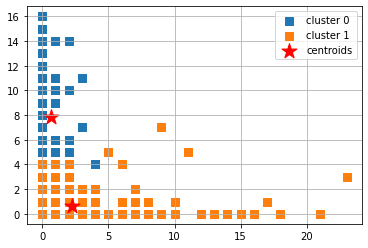

In [30]:
plot_clusters(np.array(restaurant_clustering), y_km_restaurants, plt_cluster_centers= True)

In [31]:
# Add cluster labels to venue data
restaurant_sorted.insert(0, 'clusters', kmeans.labels_)
clusters_resturant = restaurant_sorted.clusters.tolist()
restaurant_sorted = restaurant_sorted.drop('clusters', axis=1)

# Merge venue data with neighborhood data
all_restaurant_data = neighborhood_data.copy()
all_restaurant_data = pd.merge(all_restaurant_data, restaurant_sorted, on='id')
all_restaurant_data['clusters'] = clusters
all_restaurant_data = all_restaurant_data.drop('id', axis=1)

all_restaurant_data.head()

,borough,neighborhood,longitude,latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,clusters
0,Bronx,Wakefield,-73.847201,40.894705,caribbean,pizza,sandwiches,burgers,chinese,0
1,Bronx,Co-op City,-73.829939,40.874294,hotdogs,pizza,caribbean,seafood,chicken_wings,0
2,Bronx,Eastchester,-73.827806,40.887556,caribbean,hotdogs,burgers,seafood,pizza,2
3,Bronx,Fieldston,-73.905643,40.895437,bars,delis,tradamerican,mexican,pizza,0
4,Bronx,Riverdale,-73.912585,40.890834,sandwiches,delis,pizza,burgers,bars,0


### Mapping

In [32]:
# Plot clusters on map of New York
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters_resturant)
ys = [i + x + (i*x)**2 for i in range(kclusters_resturant)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(all_restaurant_data['latitude'], all_restaurant_data['longitude'], all_restaurant_data['neighborhood'],all_restaurant_data['clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [33]:
cluster0_restaurant = all_restaurant_data.loc[all_restaurant_data['clusters'] == 0, all_restaurant_data.columns[[0] + [1] + list(range(4, all_restaurant_data.shape[1]))]]
cluster1_restaurant = all_restaurant_data.loc[all_restaurant_data['clusters'] == 1, all_restaurant_data.columns[[0] + [1] + list(range(4, all_restaurant_data.shape[1]))]]

In [34]:
cluster0_restaurant

,borough,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,clusters
0,Bronx,Wakefield,caribbean,pizza,sandwiches,burgers,chinese,0
1,Bronx,Co-op City,hotdogs,pizza,caribbean,seafood,chicken_wings,0
3,Bronx,Fieldston,bars,delis,tradamerican,mexican,pizza,0
4,Bronx,Riverdale,sandwiches,delis,pizza,burgers,bars,0
6,Manhattan,Marble Hill,mexican,latin,dominican,burgers,spanish,0
...,...,...,...,...,...,...,...,...
298,Bronx,Allerton,pizza,caribbean,mexican,tradamerican,seafood,0
299,Bronx,Kingsbridge Heights,mexican,latin,chinese,tradamerican,spanish,0
300,Brooklyn,Erasmus,caribbean,seafood,cafes,bakeries,cocktailbars,0
303,Queens,Bayswater,pizza,coffee,hotdogs,burgers,diners,0


In [35]:
print('--cluster0--')
print()
print('Top 5 most common venue type')
print(cluster0_restaurant['1st Most Common Venue'].value_counts()[:5])
print()
print('Top 5 second most common venue type')
print(cluster0_restaurant['2nd Most Common Venue'].value_counts()[:5])
print()
print('Most common borough')
print(cluster0_restaurant['borough'].value_counts()[:3])

--cluster0--

Top 5 most common venue type
pizza        31
italian      31
chinese      22
mexican      19
caribbean    18
Name: 1st Most Common Venue, dtype: int64

Top 5 second most common venue type
pizza               36
chinese             22
italian             17
breakfast_brunch    16
cocktailbars        15
Name: 2nd Most Common Venue, dtype: int64

Most common borough
Queens           62
Brooklyn         53
Staten Island    43
Name: borough, dtype: int64


In [36]:
print('--cluster0--')
print()
print('Top 5 most common venue type')
print(cluster1_restaurant['1st Most Common Venue'].value_counts()[:5])
print()
print('Top 5 second most common venue type')
print(cluster1_restaurant['2nd Most Common Venue'].value_counts()[:5])
print()
print('Most common borough')
print(cluster1_restaurant['borough'].value_counts()[:3])

--cluster0--

Top 5 most common venue type
italian      7
pizza        4
caribbean    3
mexican      2
chinese      2
Name: 1st Most Common Venue, dtype: int64

Top 5 second most common venue type
pizza        6
chinese      4
delis        4
sushi        2
caribbean    2
Name: 2nd Most Common Venue, dtype: int64

Most common borough
Queens           11
Staten Island     7
Brooklyn          6
Name: borough, dtype: int64


# All Features - Not Scaled

In [37]:
neighborhood_id = pd.read_csv('/Users/karina/GitHub/NYC_midterm_project/data/old_dataset.csv')
neighborhood_id = pd.DataFrame(neighborhood_id['id'])
neighborhood_id.head()

,id
0,nyu_2451_34572.1
1,nyu_2451_34572.2
2,nyu_2451_34572.3
3,nyu_2451_34572.4
4,nyu_2451_34572.5


In [38]:
# Import venue data within 1km of each neighborhood
features_data = pd.read_csv('/Users/karina/GitHub/NYC_midterm_project/data/data/all_features_counts.csv')
features_data = features_data.iloc[:, 2:]
features_data = pd.concat([neighborhood_id, features_data], axis=1)
features_data.head()


,id,accounting,amusement_park,aquarium,art_gallery,bakery,bank,bar,beauty_salon,bicycle_store,...,pharmacy.1,farmersmarket,foodtours,bowling,syrian,southafrican,eventservices,bookstores,homedecor,diyfood
0,nyu_2451_34572.1,1,0,0,0,1,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,nyu_2451_34572.2,0,0,0,0,1,1,0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,nyu_2451_34572.3,0,0,0,0,1,0,4,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,nyu_2451_34572.4,0,0,0,1,2,0,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,nyu_2451_34572.5,0,0,0,0,0,2,5,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# Create new dataframe for most common venues
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['id']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
features_sorted = pd.DataFrame(columns=columns)
features_sorted['id'] = features_data['id']

for ind in np.arange(restaurant_data.shape[0]):
    features_sorted.iloc[ind, 1:] = return_most_common_venues(features_data.iloc[ind, :], num_top_venues)

features_sorted.head()

,id,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,nyu_2451_34572.1,caribbean,pizza,school,burgers,sandwiches
1,nyu_2451_34572.2,hotdogs,pizza,secondary_school,church,caribbean
2,nyu_2451_34572.3,doctor,caribbean,hotdogs,burgers,seafood
3,nyu_2451_34572.4,lodging,cafe,bars,night_club,delis
4,nyu_2451_34572.5,restaurant,sandwiches,burgers,pizza,delis


In [56]:
features_sorted

,id,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,nyu_2451_34572.1,caribbean,pizza,school,burgers,sandwiches
1,nyu_2451_34572.2,hotdogs,pizza,secondary_school,church,caribbean
2,nyu_2451_34572.3,doctor,caribbean,hotdogs,burgers,seafood
3,nyu_2451_34572.4,lodging,cafe,bars,night_club,delis
4,nyu_2451_34572.5,restaurant,sandwiches,burgers,pizza,delis
...,...,...,...,...,...,...
301,nyu_2451_34572.302,doctor,newamerican,cocktailbars,breakfast_brunch,italian
302,nyu_2451_34572.303,doctor,pizza,chinese,sandwiches,dentist
303,nyu_2451_34572.304,bar,restaurant,lodging,pizza,bakery
304,nyu_2451_34572.305,bar,restaurant,burgers,breakfast_brunch,chinese


In [40]:
# Drop neighborhood ID to create numerical data for k-means clustering
features_clustering = features_data.drop('id', axis=1)

In [41]:
# Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_scaled = pd.DataFrame(scaler.fit_transform(features_clustering))
features_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,314,315,316,317,318,319,320,321,322,323
0,0.870296,-0.05726,-0.05726,-0.304725,0.524484,1.465681,-0.476286,-0.493993,-0.212622,-0.32431,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
1,-0.546249,-0.05726,-0.05726,-0.304725,0.524484,0.374444,-0.476286,2.590942,-0.212622,-0.32431,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
2,-0.546249,-0.05726,-0.05726,-0.304725,0.524484,-0.716793,0.774732,1.048474,-0.212622,-0.32431,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
3,-0.546249,-0.05726,-0.05726,3.281651,1.759037,-0.716793,0.774732,-0.493993,-0.212622,-0.32431,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726
4,-0.546249,-0.05726,-0.05726,-0.304725,-0.710070,1.465681,1.087487,-0.493993,-0.212622,-0.32431,...,-0.05726,-0.05726,-0.099504,-0.099504,-0.081111,-0.05726,-0.05726,-0.099504,-0.099504,-0.05726


### K-Means

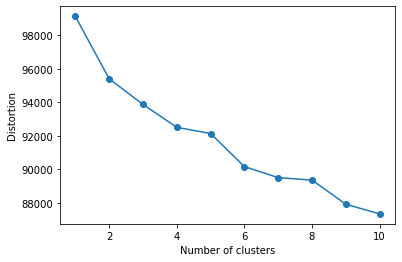

In [42]:
# Plot elbow graph
plot_distortion(features_scaled)

In [43]:
# Cluster data points using kmeans and get labels
kclusters_features = 8

kmeans_features = KMeans(n_clusters=kclusters_features, random_state=0).fit(features_clustering)

kmeans_features.labels_[0:10] 

array([4, 4, 2, 5, 6, 2, 6, 6, 6, 4], dtype=int32)

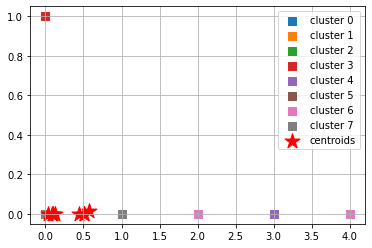

In [44]:
y_km_features = kmeans_features.fit_predict(features_clustering)
plot_clusters(np.array(features_clustering), y_km_features, plt_cluster_centers= True)

In [45]:
# Add cluster labels to venue data
features_sorted.insert(0, 'clusters', kmeans_features.labels_)
clusters = features_sorted.clusters.tolist()
features_sorted = features_sorted.drop('clusters', axis=1)

# Merge venue data with neighborhood data
all_features_data = neighborhood_data.copy()
all_features_data = pd.merge(all_features_data, features_sorted, on='id')
all_features_data['clusters'] = clusters
all_features_data = all_features_data.drop('id', axis=1)

all_features_data.head()

,borough,neighborhood,longitude,latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,clusters
0,Bronx,Wakefield,-73.847201,40.894705,caribbean,pizza,school,burgers,sandwiches,4
1,Bronx,Co-op City,-73.829939,40.874294,hotdogs,pizza,secondary_school,church,caribbean,4
2,Bronx,Eastchester,-73.827806,40.887556,doctor,caribbean,hotdogs,burgers,seafood,2
3,Bronx,Fieldston,-73.905643,40.895437,lodging,cafe,bars,night_club,delis,5
4,Bronx,Riverdale,-73.912585,40.890834,restaurant,sandwiches,burgers,pizza,delis,6


In [46]:
all_features_data.clusters.unique()

array([4, 2, 5, 6, 7, 0, 1, 3])

### Mapping

In [47]:
# Plot clusters on map of New York
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters_features)
ys = [i + x + (i*x)**2 for i in range(kclusters_features)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(all_features_data['latitude'], all_features_data['longitude'], all_features_data['neighborhood'],all_features_data['clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [48]:
cluster0_features = all_features_data.loc[all_features_data['clusters'] == 0, all_features_data.columns[[0] + [1] + list(range(4, all_features_data.shape[1]))]]
cluster1_features = all_features_data.loc[all_features_data['clusters'] == 1, all_features_data.columns[[0] + [1] + list(range(4, all_features_data.shape[1]))]]
cluster2_features = all_features_data.loc[all_features_data['clusters'] == 2, all_features_data.columns[[0] + [1] + list(range(4, all_features_data.shape[1]))]]
cluster3_features = all_features_data.loc[all_features_data['clusters'] == 3, all_features_data.columns[[0] + [1] + list(range(4, all_features_data.shape[1]))]]
cluster4_features = all_features_data.loc[all_features_data['clusters'] == 4, all_features_data.columns[[0] + [1] + list(range(4, all_features_data.shape[1]))]]
cluster5_features = all_features_data.loc[all_features_data['clusters'] == 5, all_features_data.columns[[0] + [1] + list(range(4, all_features_data.shape[1]))]]

In [49]:
cluster0_features

,borough,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,clusters
15,Bronx,Morris Heights,lodging,bar,latin,restaurant,mexican,0
16,Bronx,Fordham,italian,lodging,restaurant,seafood,latin,0
19,Bronx,High Bridge,lodging,restaurant,mexican,latin,lawyer,0
20,Bronx,Melrose,mexican,lodging,bar,caribbean,seafood,0
21,Bronx,Mott Haven,mexican,bar,restaurant,clothing_store,lodging,0
22,Bronx,Port Morris,mexican,night_club,restaurant,lodging,bar,0
24,Bronx,Hunts Point,bar,restaurant,lodging,night_club,tourist_attraction,0
25,Bronx,Morrisania,lodging,mexican,restaurant,latin,bar,0
26,Bronx,Soundview,lodging,burgers,hotdogs,pizza,chicken_wings,0
27,Bronx,Clason Point,lodging,bar,bakery,clothing_store,shoe_store,0


In [50]:
print('--cluster0--')
print()
print('Top 5 most common venue type')
print(cluster0_features['1st Most Common Venue'].value_counts()[:5])
print()
print('Top 5 second most common venue type')
print(cluster0_features['2nd Most Common Venue'].value_counts()[:5])
print()
print('Most common borough')
print(cluster0_features['borough'].value_counts()[:3])

--cluster0--

Top 5 most common venue type
lodging       8
bar           5
mexican       4
restaurant    2
italian       1
Name: 1st Most Common Venue, dtype: int64

Top 5 second most common venue type
restaurant    8
bar           5
lodging       3
night_club    1
mexican       1
Name: 2nd Most Common Venue, dtype: int64

Most common borough
Bronx     18
Queens     5
Name: borough, dtype: int64


In [51]:
print('--cluster1--')
print()
print('Top 5 most common venue type')
print(cluster1_features['1st Most Common Venue'].value_counts()[:5])
print()
print('Top 5 second most common venue type')
print(cluster1_features['2nd Most Common Venue'].value_counts()[:5])
print()
print('Most common borough')
print(cluster1_features['borough'].value_counts()[:3])

--cluster1--

Top 5 most common venue type
doctor        11
health         4
restaurant     4
chinese        3
korean         3
Name: 1st Most Common Venue, dtype: int64

Top 5 second most common venue type
health                5
doctor                5
pizza                 4
general_contractor    3
delis                 3
Name: 2nd Most Common Venue, dtype: int64

Most common borough
Staten Island    22
Queens           16
Brooklyn          5
Name: borough, dtype: int64


In [52]:
print('--cluster2--')
print()
print('Top 5 most common venue type')
print(cluster2_features['1st Most Common Venue'].value_counts()[:5])
print()
print('Top 5 second most common venue type')
print(cluster2_features['2nd Most Common Venue'].value_counts()[:5])
print()
print('Most common borough')
print(cluster2_features['borough'].value_counts()[:3])

--cluster2--

Top 5 most common venue type
doctor    32
Name: 1st Most Common Venue, dtype: int64

Top 5 second most common venue type
italian         6
pizza           3
chinese         2
seafood         2
cocktailbars    2
Name: 2nd Most Common Venue, dtype: int64

Most common borough
Staten Island    14
Bronx             5
Brooklyn          5
Name: borough, dtype: int64


In [53]:
print('--cluster3--')
print()
print('Top 5 most common venue type')
print(cluster3_features['1st Most Common Venue'].value_counts()[:5])
print()
print('Top 5 second most common venue type')
print(cluster3_features['2nd Most Common Venue'].value_counts()[:5])
print()
print('Most common borough')
print(cluster3_features['borough'].value_counts()[:3])

--cluster3--

Top 5 most common venue type
cocktailbars        13
newamerican         11
breakfast_brunch    10
italian              8
doctor               8
Name: 1st Most Common Venue, dtype: int64

Top 5 second most common venue type
cocktailbars        14
newamerican         10
italian              9
breakfast_brunch     7
mexican              3
Name: 2nd Most Common Venue, dtype: int64

Most common borough
Manhattan    32
Brooklyn     20
Queens        6
Name: borough, dtype: int64


In [54]:
print('--cluster4--')
print()
print('Top 5 most common venue type')
print(cluster4_features['1st Most Common Venue'].value_counts()[:5])
print()
print('Top 5 second most common venue type')
print(cluster4_features['2nd Most Common Venue'].value_counts()[:5])
print()
print('Most common borough')
print(cluster4_features['borough'].value_counts()[:3])

--cluster4--

Top 5 most common venue type
caribbean    15
doctor        8
pizza         4
chinese       2
halal         2
Name: 1st Most Common Venue, dtype: int64

Top 5 second most common venue type
chinese             11
caribbean            5
pizza                4
doctor               3
breakfast_brunch     2
Name: 2nd Most Common Venue, dtype: int64

Most common borough
Brooklyn    16
Queens      11
Bronx       10
Name: borough, dtype: int64


In [55]:
print('--cluster5--')
print()
print('Top 5 most common venue type')
print(cluster5_features['1st Most Common Venue'].value_counts()[:5])
print()
print('Top 5 second most common venue type')
print(cluster5_features['2nd Most Common Venue'].value_counts()[:5])
print()
print('Most common borough')
print(cluster5_features['borough'].value_counts()[:3])

--cluster5--

Top 5 most common venue type
lodging    8
Name: 1st Most Common Venue, dtype: int64

Top 5 second most common venue type
chinese           2
cafe              1
pizza             1
caribbean         1
clothing_store    1
Name: 2nd Most Common Venue, dtype: int64

Most common borough
Bronx     4
Queens    4
Name: borough, dtype: int64


In [70]:
df = neighborhood_data.copy()
v3 = pd.read_csv('/Users/karina/GitHub/NYC_midterm_project/data/data/all_features_counts_V3.csv')
v3 = v3.iloc[:,]


In [71]:
df = pd.DataFrame(df.id)


In [61]:
v3.head()

,Unnamed: 0,population,index,lodging,restaurant,school,health,bar,church,bank,...,pharmacy,farmersmarket,foodtours,bowling,syrian,southafrican,eventservices,bookstores,homedecor,diyfood
0,0,21242.0,nyu_2451_34572.0,9,55,26,13,10,60,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,43752.0,nyu_2451_34572.1,5,39,26,7,4,25,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,11506.0,nyu_2451_34572.2,3,33,16,3,11,23,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,9287.0,nyu_2451_34572.3,2,54,27,7,14,5,24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,9287.0,nyu_2451_34572.4,3,20,25,9,16,12,23,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
